In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from tqdm import tqdm

In [3]:
# defining parameters from Krishna/Jensen

k_Nin = 5.4 # min^{-1}
k_lin = 0.018 # min^{-1} 
k_t = 1.03 # mu * M^{-1} * min^{-1}
k_tl = 0.24 # min^{-1}
K_I = 0.035 # mu * M
K_N = 0.029 # mu * M
gamma_m = 0.017 # min^{-1}
alpha = 1.05 # mu * M^{-1} * min^{-1}
N_tot = 1.0 # mu * M
k_a = 0.24 # min^{-1}
k_i = 0.18 # min^{-1}
k_p = 0.036 # min^{-1}
k_A20 = 0.0018 # mu * M
IKK_tot = 2.0 # mu * M
A20 = 0.0026 # mu * M

In [4]:
# defining time
time = (0, 5000)

# defining constant to keep TNF>0
k = 0.5

# definerer startparameters
N_n0, I_m0, I0, IKK_a0, IKK_i0, TNF_k = 1, 0.5, 0.5, 0.5, 0.5, k
y0 = [N_n0, I_m0, I0, IKK_a0, IKK_i0, TNF_k]

In [10]:
# defining omega, number of oscillations, amplitude, TNF_0 and start parameters as the last values of the first simulation
omega = 1
no_osc = 50
Amp1 = 0.24
T_intt = 108.44444444444444
A_intt = 0.1293511878383227
p0 = [0.037770776771579556, 0.4050017925580332, 4.076546559955566, 0.1799999999999995, 1.5500000000000012]

T_extt = omega * T_intt

In [11]:
# defining equations from Krishna/Jensen
def N_n_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dN_ndt = k_Nin * (N_tot - N_n) * K_I / (K_I + I) - k_lin * I * (N_n / (K_N + N_n))
    return dN_ndt

def I_m_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dI_mdt = k_t * (N_n**2) - gamma_m * I_m
    return dI_mdt

def I_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIdt = k_tl * I_m - alpha * IKK_a * (N_tot - N_n) * I / (K_I + I)
    return dIdt

def IKK_a_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIKK_adt = k_a * TNF * (IKK_tot - IKK_a - IKK_i) - k_i * IKK_a
    return dIKK_adt

def IKK_i_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIKK_idt = k_i * IKK_a - k_p * IKK_i * k_A20 / (k_A20 + A20 * TNF)
    return dIKK_idt

def system_nfkb(t, y, Amp_new):
    # Extract current state variables, assume TNF is not part of y here
    N_n, I_m, I, IKK_a, IKK_i = y
    # Dynamically compute TNF based on current time t (this means it will be a constant passed to the next equations for this dt)
    TNF = k + Amp_new * np.sin(np.pi * (1 / T_extt) * t*2*np.pi)
    # calling differential equation functions, passing TNF as an argument
    # Updating function definitions accordingly if they require TNF
    return [N_n_change(t, *y, TNF), 
            I_m_change(t, *y, TNF), 
            I_change(t, *y, TNF), 
            IKK_a_change(t, *y, TNF), 
            IKK_i_change(t, *y, TNF)]

In [49]:
# defining function to oscillate TNF (sinusoidal)
def TNF_sin_osc(oscillations, Amp):

    history = {"t":[] ,"N_n": [], "I_m": [], "I": [], "IKK_a":[], "IKK_i":[], "TNF":[]}

    
    for i in tqdm(range(oscillations)):
        if i == 0:
            state = p0
        else:
            state = history["N_n"][-1], history["I_m"][-1], history["I"][-1], history["IKK_a"][-1], history["IKK_i"][-1]

        sys = solve_ivp(system_nfkb, (0, T_extt), state, args=(Amp,), method='RK45', max_step=0.1, dense_output=True) # Is this step size too low?
        
        N_n, I_m, I, IKK_a, IKK_i = sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]

        new_t = np.array(sys["t"]) + (history["t"][-1] if history["t"] else 0)
        history["t"].extend(new_t)
        history["N_n"].extend(N_n)
        history["I_m"].extend(I_m)
        history["I"].extend(I)
        history["IKK_a"].extend(IKK_a)
        history["IKK_i"].extend(IKK_i)
        history["TNF"].extend(k + Amp * np.sin(np.pi * (1 / T_extt) * new_t))

    return history

In [ ]:
# why does the amplitude og NFKB keep changing?
def multi_amplitude_plot(A_min, A_max, stepsize):
    
    Amp_arr = np.linspace(A_min, A_max, stepsize)

    all_sims = []

    for i in range(stepsize):
        print("Simulation nr.: ", i)
        TNF_simi = TNF_sin_osc(no_osc, Amp_arr[i])
        ti, N_ni, I_mi, Ii, IKK_ai, IKK_ii, TNFi = np.array(TNF_simi["t"]), np.array(TNF_simi["N_n"]), np.array(TNF_simi["I_m"]), np.array(TNF_simi["I"]), np.array(TNF_simi["IKK_a"]), np.array(TNF_simi["IKK_i"]), np.array(TNF_simi["TNF"])
        all_sims.append([ti, N_ni, TNFi, I_mi, Ii, IKK_ai, IKK_ii])
    return all_sims

In [55]:
A_min = 0.2
A_max = 0.225
stepsize = 5

sims = multi_amplitude_plot(A_min, A_max, stepsize)

Simulation nr.:  0


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:07<00:00,  6.31it/s]


Simulation nr.:  1


100%|██████████| 50/50 [00:07<00:00,  6.72it/s]


Simulation nr.:  2


100%|██████████| 50/50 [00:07<00:00,  6.78it/s]


Simulation nr.:  3


100%|██████████| 50/50 [00:07<00:00,  6.73it/s]


Simulation nr.:  4


100%|██████████| 50/50 [00:07<00:00,  6.87it/s]


In [81]:
len(sims[0][0])

7

In [74]:
print([len(sim) for sim in sims])

[[[array([0.00000000e+00, 1.00000000e-01, 2.00000000e-01, ...,
       5.42207778e+03, 5.42217778e+03, 5.42222222e+03]), array([0.03777078, 0.03804472, 0.03832186, ..., 0.02285079, 0.02304637,
       0.02313442]), array([0.5       , 0.50057939, 0.50115878, ..., 0.4991631 , 0.49974249,
       0.5       ]), array([0.40500179, 0.40446176, 0.4039248 , ..., 0.36770366, 0.36713329,
       0.36688041]), array([4.07654656, 4.06823112, 4.05990593, ..., 4.68650538, 4.67299723,
       4.66697665]), array([0.18      , 0.18001166, 0.18004608, ..., 0.2190312 , 0.21947022,
       0.21965975]), array([1.55      , 1.550005  , 1.55002023, ..., 1.50040894, 1.50157513,
       1.50209679])], [array([0.00000000e+00, 1.00000000e-01, 2.00000000e-01, ...,
       5.42207778e+03, 5.42217778e+03, 5.42222222e+03]), array([0.03777078, 0.03804472, 0.03832186, ..., 0.02184525, 0.02203014,
       0.02211337]), array([0.5       , 0.5005975 , 0.50119499, ..., 0.49913695, 0.49973445,
       0.5       ]), array([0.40500179

In [87]:
all_t = [sim for sim in sims[0]]

In [88]:
all_t

[[array([0.00000000e+00, 1.00000000e-01, 2.00000000e-01, ...,
         5.42207778e+03, 5.42217778e+03, 5.42222222e+03]),
  array([0.03777078, 0.03804472, 0.03832186, ..., 0.02285079, 0.02304637,
         0.02313442]),
  array([0.5       , 0.50057939, 0.50115878, ..., 0.4991631 , 0.49974249,
         0.5       ]),
  array([0.40500179, 0.40446176, 0.4039248 , ..., 0.36770366, 0.36713329,
         0.36688041]),
  array([4.07654656, 4.06823112, 4.05990593, ..., 4.68650538, 4.67299723,
         4.66697665]),
  array([0.18      , 0.18001166, 0.18004608, ..., 0.2190312 , 0.21947022,
         0.21965975]),
  array([1.55      , 1.550005  , 1.55002023, ..., 1.50040894, 1.50157513,
         1.50209679])],
 [array([0.00000000e+00, 1.00000000e-01, 2.00000000e-01, ...,
         5.42207778e+03, 5.42217778e+03, 5.42222222e+03]),
  array([0.03777078, 0.03804472, 0.03832186, ..., 0.02184525, 0.02203014,
         0.02211337]),
  array([0.5       , 0.5005975 , 0.50119499, ..., 0.49913695, 0.49973445,
    

In [92]:
Amp_arr = np.linspace(A_min, A_max, stepsize)
all_t = [sim[0] for sim in sims[0]]
all_N_n = [sim[1] for sim in sims[0]]
all_TNF = [sim[2] for sim in sims[0]]
all_Im = [sim[3] for sim in sims[0]]
all_I = [sim[4] for sim in sims[0]]
all_IKKa = [sim[5] for sim in sims[0]]
all_IKK = [sim[6] for sim in sims[0]]

In [93]:
all_t

[array([0.00000000e+00, 1.00000000e-01, 2.00000000e-01, ...,
        5.42207778e+03, 5.42217778e+03, 5.42222222e+03]),
 array([0.00000000e+00, 1.00000000e-01, 2.00000000e-01, ...,
        5.42207778e+03, 5.42217778e+03, 5.42222222e+03]),
 array([0.00000000e+00, 1.00000000e-01, 2.00000000e-01, ...,
        5.42207778e+03, 5.42217778e+03, 5.42222222e+03]),
 array([0.00000000e+00, 1.00000000e-01, 2.00000000e-01, ...,
        5.42207778e+03, 5.42217778e+03, 5.42222222e+03]),
 array([0.00000000e+00, 1.00000000e-01, 2.00000000e-01, ...,
        5.42207778e+03, 5.42217778e+03, 5.42222222e+03])]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


TypeError: 'float' object is not subscriptable

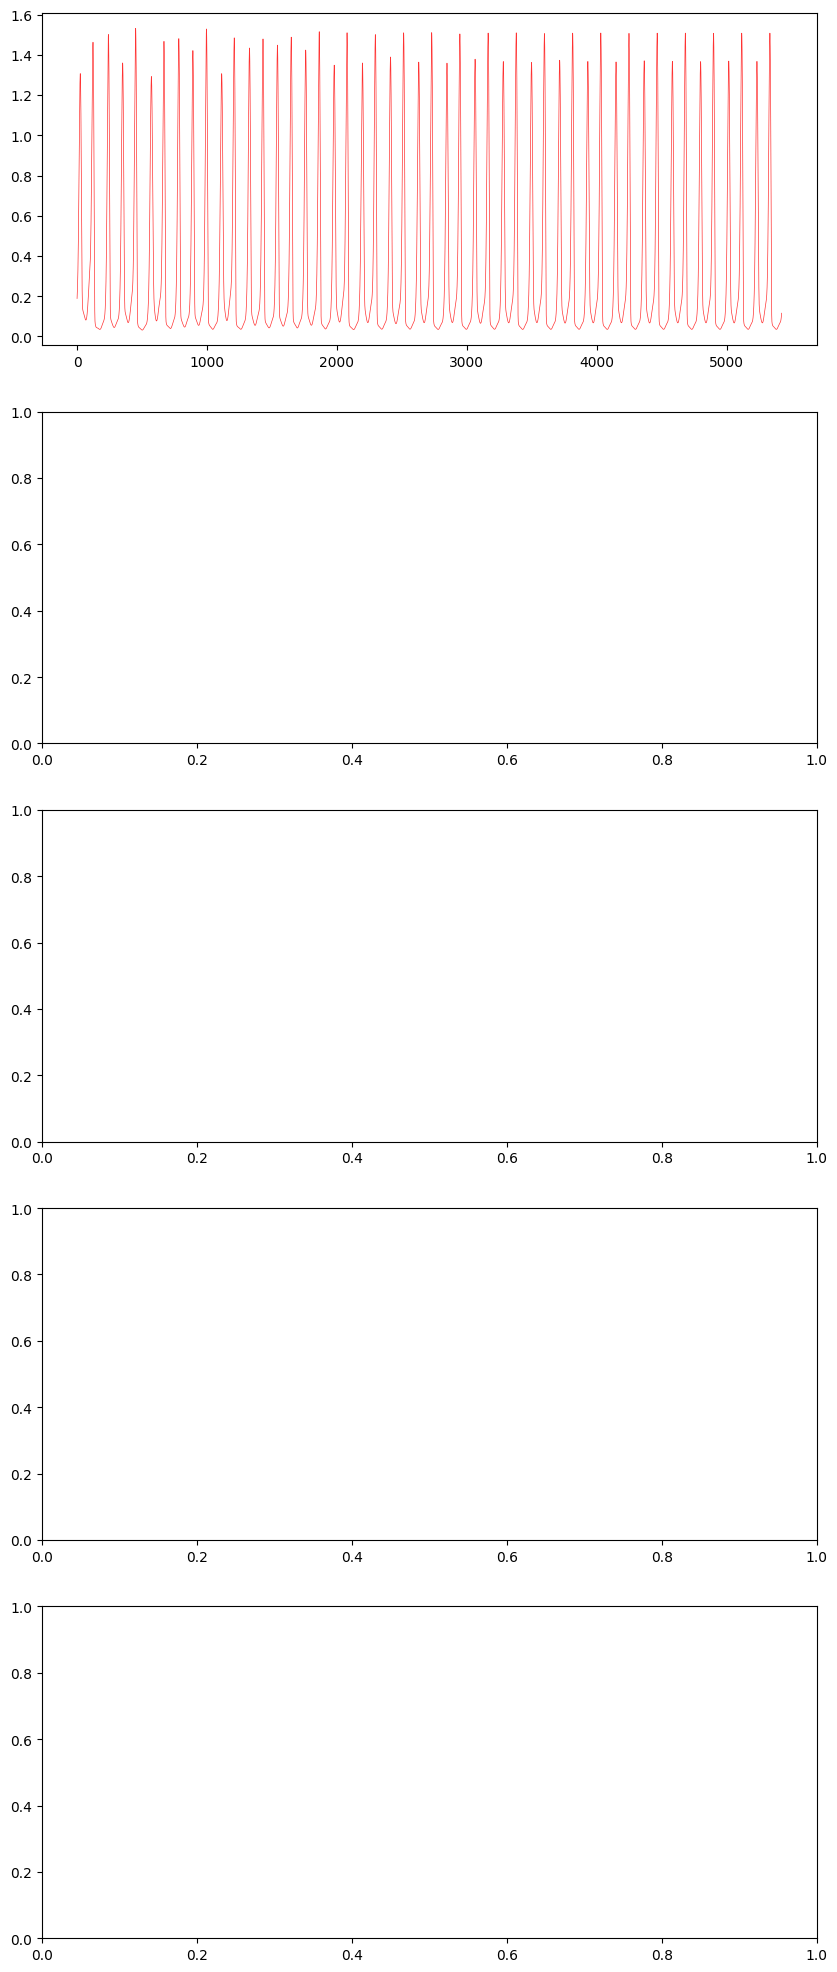

In [94]:
figure, axis = plt.subplots(stepsize, figsize=[10,stepsize*5])
x=5
for i in tqdm(range(stepsize)):
        axis[i].plot(all_t[i], x*all_N_n[i], color="#FF0000", alpha=0.8, lw=0.5, label = f'{x}x  NF$\kappa$B')
        axis[i].plot(all_t[i], all_TNF[i], alpha=1, color="#03FF00", lw=0.5, label = f'TNF with T = {T_extt[i]:.4}, A = {Amp_arr[i]}')
        axis[i].set_title(rf'(Sim. Nr.: {i}) Sinusoidal oscillation: $\Omega$ = {omega}/1, A={Amp_arr[i]}')
        axis[i].legend();  
for ax in axis.flat:
    ax.set(xlabel='time [min.]', ylabel='concentration')
for ax in axis.flat:
    ax.label_outer()

    plt.tight_layout()